In [2]:
import os
import uuid
import random
import psycopg2
import numpy as np
import scipy.interpolate
import scipy.io as sio
import matplotlib.cm as cm
import matplotlib.tri as mtri
import matplotlib.pyplot as plt

from psycopg2 import Error
from scipy.fft import fft, rfftfreq

In [3]:
__connection = psycopg2.connect(user="postgres",
                                     password='2325070307',
                                     host="127.0.0.1",
                                     port="5432",
                                     database='tpu')
cursor = __connection.cursor()

In [4]:
alpha = 4
model_name = '111'
angle = 0

In [49]:
if alpha == '4' or alpha == 4:
    cursor.execute("""
                select pressure_coefficients
                from models_alpha_4
                where model_id = (
                select model_id
                from experiments_alpha_4
                where model_name = (%s)
                ) and angle = (%s)
            """, (model_name, angle))

elif alpha == '6' or alpha == 6:
    cursor.execute("""
                select pressure_coefficients
                from models_alpha_6
                where model_id = (
                select model_id
                from experiments_alpha_6
                where model_name = (%s)
                ) and angle = (%s)
            """, (model_name, angle))
__connection.commit()
pressure_coefficients = cursor.fetchall()[0][0]

In [50]:
pr_norm = np.array(pressure_coefficients)/1000

In [24]:
if alpha == '4' or alpha == 4:
    cursor.execute("""
                select x_coordinates, z_coordinates
                from experiments_alpha_4
                where model_name = (%s)
            """, (model_name,))

elif alpha == '6' or alpha == 6:
    cursor.execute("""
                select x_coordinates, z_coordinates
                from experiments_alpha_6
                where model_name = (%s)
            """, (model_name,))
__connection.commit()
x, z = cursor.fetchall()[0]

In [29]:
breadth, depth, height = int(model_name[0]) / 10, int(model_name[1]) / 10, int(model_name[2]) / 10
count_sensors_on_model = len(pr_norm[0])
count_sensors_on_middle = int(model_name[0]) * 5
count_sensors_on_side = int(model_name[1]) * 5
count_row = count_sensors_on_model // (2 * (count_sensors_on_middle + count_sensors_on_side))
s13_row = height*breadth/count_row
s24_row = height*depth/count_row
v2 = breadth
v3 = breadth + depth
v4 = 2 * breadth + depth
mid13 = breadth / 2
mid24 = depth / 2

In [26]:
x = np.reshape(x, (count_row, -1))
x = np.split(x, [count_sensors_on_middle,
                 count_sensors_on_middle + count_sensors_on_side,
                 2 * count_sensors_on_middle + count_sensors_on_side,
                 2 * (count_sensors_on_middle + count_sensors_on_side)
                 ], axis=1)

z = np.reshape(z, (count_row, -1))
z = np.split(z, [count_sensors_on_middle,
                 count_sensors_on_middle + count_sensors_on_side,
                 2 * count_sensors_on_middle + count_sensors_on_side,
                 2 * (count_sensors_on_middle + count_sensors_on_side)
                 ], axis=1)

del x[4]
del z[4]

In [27]:
x[1] -= v2
x[2] -= v3
x[3] -= v4

In [28]:
x

[array([[0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09]]),
 array([[0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09]]),
 array([[0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09]]),
 array([[0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09]])]

In [40]:
Cmz = np.array([
    abs(x[0] - mid13),
    abs(x[1] - mid24),
    abs(x[2] - mid13),
    abs(x[3] - mid24),
])

In [47]:
Cmz

array([[[4.00000000e-02, 2.00000000e-02, 0.00000000e+00, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 0.00000000e+00, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 0.00000000e+00, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 0.00000000e+00, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 0.00000000e+00, 2.00000000e-02,
         4.00000000e-02]],

       [[4.00000000e-02, 2.00000000e-02, 1.38777878e-17, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 1.38777878e-17, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 1.38777878e-17, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 1.38777878e-17, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 1.38777878e-17, 2.00000000e-02,
         4.00000000e-02]],

      

In [45]:
mean_pr = np.mean(pr_norm, axis=0)
mean_pr = np.reshape(mean_pr, (count_row, -1))
mean_pr = np.split(mean_pr, [count_sensors_on_middle,
                             count_sensors_on_middle + count_sensors_on_side,
                             2 * count_sensors_on_middle + count_sensors_on_side,
                             2 * (count_sensors_on_middle + count_sensors_on_side)
                             ], axis=1)
del mean_pr[4]

In [46]:
mean_pr

[array([[0.51173145, 0.58168579, 0.57018643, 0.54870935, 0.44975803],
        [0.54667944, 0.71888873, 0.72858423, 0.68344635, 0.4736745 ],
        [0.49859189, 0.68173242, 0.69527313, 0.64602206, 0.42419742],
        [0.39864905, 0.60219879, 0.62165945, 0.57183356, 0.34624313],
        [0.30428436, 0.60428995, 0.60816455, 0.54236789, 0.25801105]]),
 array([[-1.06746436, -1.02606631, -0.82900681, -0.63412991, -0.48221805],
        [-0.9843754 , -1.00815634, -0.86998398, -0.66285165, -0.51597342],
        [-0.91717691, -0.94771606, -0.85600061, -0.67179385, -0.5462598 ],
        [-0.90330771, -0.92484961, -0.8158331 , -0.64715549, -0.54567532],
        [-0.90633609, -0.87455597, -0.73389041, -0.58050357, -0.49409467]]),
 array([[-0.41566028, -0.40210699, -0.39262744, -0.39085339, -0.39245786],
        [-0.42522308, -0.41217166, -0.4065318 , -0.40805316, -0.40368594],
        [-0.42707245, -0.40564609, -0.3917818 , -0.39431317, -0.40316962],
        [-0.41536929, -0.3857984 , -0.37186005

In [48]:
mean_pr * Cmz

array([[[ 2.04692578e-02,  1.16337158e-02,  0.00000000e+00,
          1.09741870e-02,  1.79903210e-02],
        [ 2.18671777e-02,  1.43777747e-02,  0.00000000e+00,
          1.36689270e-02,  1.89469800e-02],
        [ 1.99436755e-02,  1.36346484e-02,  0.00000000e+00,
          1.29204413e-02,  1.69678967e-02],
        [ 1.59459619e-02,  1.20439758e-02,  0.00000000e+00,
          1.14366711e-02,  1.38497253e-02],
        [ 1.21713745e-02,  1.20857990e-02,  0.00000000e+00,
          1.08473578e-02,  1.03204419e-02]],

       [[-4.26985742e-02, -2.05213263e-02, -1.15047805e-17,
         -1.26825983e-02, -1.92887219e-02],
        [-3.93750159e-02, -2.01631268e-02, -1.20734530e-17,
         -1.32570331e-02, -2.06389368e-02],
        [-3.66870764e-02, -1.89543213e-02, -1.18793948e-17,
         -1.34358771e-02, -2.18503918e-02],
        [-3.61323083e-02, -1.84969922e-02, -1.13219586e-17,
         -1.29431097e-02, -2.18270129e-02],
        [-3.62534436e-02, -1.74911194e-02, -1.01847754e-17,
  

In [52]:
sum_x = []
sum_y = []
qq1 = []
qq2 = []

for coeff in pr_norm:
    coeff = np.reshape(coeff, (count_row, -1))
    coeff = np.split(coeff, [count_sensors_on_middle,
                             count_sensors_on_middle + count_sensors_on_side,
                             2 * count_sensors_on_middle + count_sensors_on_side,
                             2 * (count_sensors_on_middle + count_sensors_on_side)
                             ], axis=1)
    del coeff[4]
    faces_x = []
    faces_y = []
    coeff = coeff*Cmz
    for face in range(len(coeff)):
        if face in [0,2]:
            faces_x.append(np.sum(coeff[face])/(count_sensors_on_model/4))
        else:
            faces_y.append(np.sum(coeff[face])/(count_sensors_on_model/4))
    qq1.append(faces_x[0])
    qq2.append(faces_x[1])
    
    sum_x.append((faces_x[0]-faces_x[1]))
    sum_y.append((faces_y[0]-faces_y[1]))
    

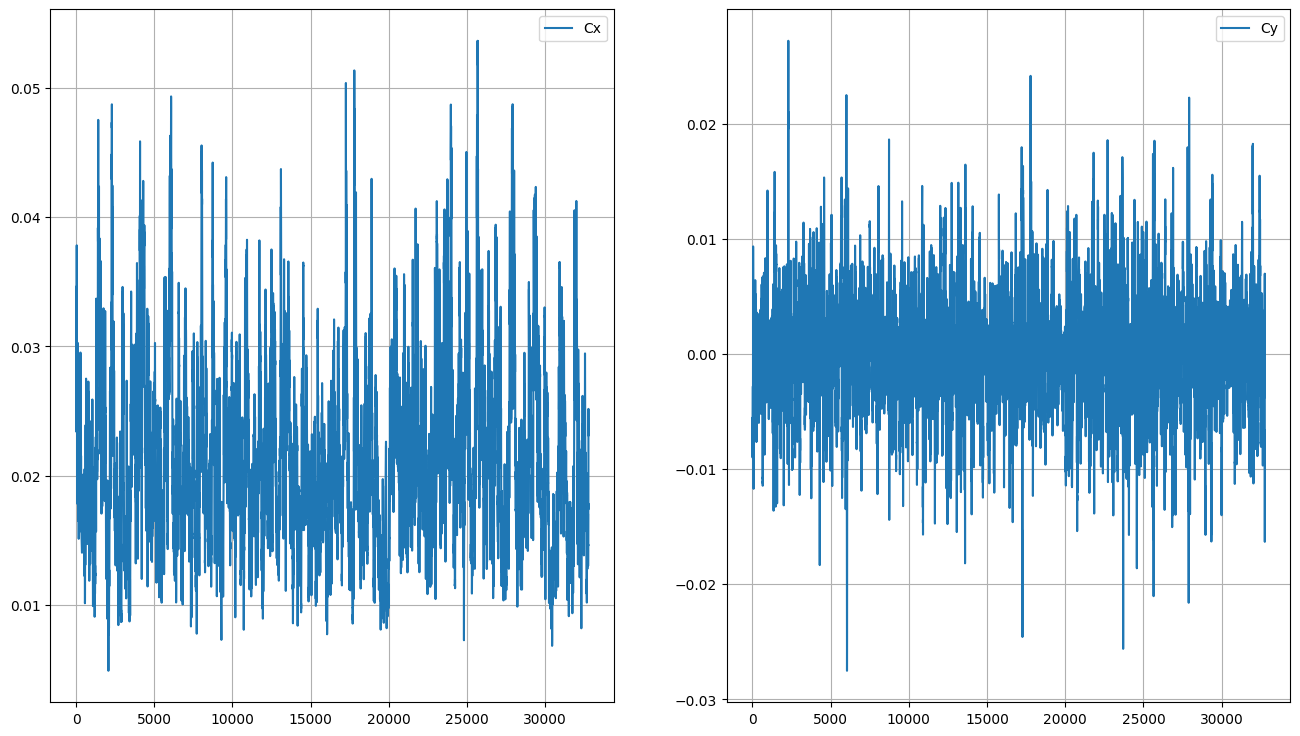

In [53]:
fig,graph = plt.subplots(1,2,figsize=(16,9))
graph[0].plot(list(range(1,32769)),sum_x,label='Cx')
graph[1].plot(list(range(1,32769)),sum_y,label='Cy')
graph[0].legend()
graph[1].legend()
graph[0].grid()
graph[1].grid()
plt.show()

In [54]:
count_sensors_on_model

100